# Ticket inspection AI

## Config

In [1028]:
IS_WINDOWS = False
SAVE_AS_BEST = False
OLD_LINJE_TO_NEW = True

# Trials
TWO_TRIALS = 750
FOUR_TRIALS = 2_000

## Imports

In [1029]:
import optuna as opt
import os
import pandas as pd
from sdv.evaluation import evaluate
from sdv.tabular import GaussianCopula
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import xgboost as xgb

## Functions

In [1030]:
from utils.utils import *

### Functions for running recursion on lines

In [1031]:
from utils.recursive_utils import *

# Reading data

In [1032]:
if IS_WINDOWS:
    db_main = pd.read_excel('C:/Users/sigzu/OneDrive/Dokumenter/Andre Dokumenter/Billettkontroll data/Billettkontroll data.xlsx')
    db_aanerud = pd.read_excel('C:/Users/sigzu/OneDrive/Dokumenter/Andre Dokumenter/Billettkontroll data/Billettkontroll data-aanerud.xlsx')
else:
    db_main = pd.read_excel("/Users/sigurdskyrud/OneDrive/Dokumenter/Andre Dokumenter/Billettkontroll data/Billettkontroll data.xlsx")
    db_aanerud = pd.read_excel("/Users/sigurdskyrud/OneDrive/Dokumenter/Andre Dokumenter/Billettkontroll data/Billettkontroll data-aanerud.xlsx")

db_aanerud.head(3)

,Linje,Vogn,Dato,Klokke,Fra,Til,Fullt?,Sjekket?,Merknad
0,R14,Fremst,2023-01-21,16:54:00,Skarnes,Oslo s,Nei,Nei,NaN
1,R14,NaN,2023-01-22,17:04:00,Oslo s,Kongsvinger,Nei,Ja,Ble sjekket med en gang toget reiste
2,R14,4,2023-01-27,16:32:00,Oslo s,Årnes,Nei,Nei,NaN


In [1033]:
db = pd.concat([db_main, db_aanerud])
db.tail(2)

,Linje,Vogn,Dato,Klokke,Fra,Til,Fullt?,Sjekket?,Merknad
12,R14,5,2023-05-04,14:04:00,Oslo s,Skarnes,Nei,Nei,NaN
13,R14,Fremst,2023-05-10,16:32:00,Oslo s,Skarnes,Nei,Nei,NaN


In [1034]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 0 to 13
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Linje     162 non-null    object        
 1   Vogn      159 non-null    object        
 2   Dato      162 non-null    datetime64[ns]
 3   Klokke    162 non-null    object        
 4   Fra       162 non-null    object        
 5   Til       162 non-null    object        
 6   Fullt?    162 non-null    object        
 7   Sjekket?  162 non-null    object        
 8   Merknad   63 non-null     object        
dtypes: datetime64[ns](1), object(8)
memory usage: 12.7+ KB


# Data cleaning and engineering

## Categorize the features

In [1035]:
db = db.fillna(-1)

Converts old lines to new if configured

In [1036]:
db["Linje"] = db["Linje"].apply(lambda x: strCleaner(x))

# Converts old lines to new
if OLD_LINJE_TO_NEW:
    db["Linje"] = db["Linje"].apply(lambda x: convert_linje_to_new(x))

Extract date sub-categories

In [1037]:
db["Dag"] = db["Dato"].apply(lambda x: extractDay(x))
db["Måned"] = db["Dato"].apply(lambda x: extractMonth(x))
# db["År"] = db["Dato"].apply(lambda x: extractYear(x)) # Not relevant for the timescale I have

db = db.drop("Dato", axis=1)
db.head(3)

,Linje,Vogn,Klokke,Fra,Til,Fullt?,Sjekket?,Merknad,Dag,Måned
0,r12,Fremst,11:30:00,Eidsvoll,Oslo Lufthavn,Nei,Nei,-1,25,9
1,re10,Bakerst,21:59:00,Oslo Lufthavn,Eidsvoll,Ja,Ja,-1,25,9
2,r12,Fremst,09:30:00,Eidsvoll,Nationaltheatret,Ja,Nei,-1,26,9


Exctract time sub-categories

In [1038]:
db["Time"] = db["Klokke"].apply(lambda x: extractHour(x))
db["Minutt"] = db["Klokke"].apply(lambda x: extractMinute(x))

db = db.drop("Klokke", axis=1)
db.head(3)

,Linje,Vogn,Fra,Til,Fullt?,Sjekket?,Merknad,Dag,Måned,Time,Minutt
0,r12,Fremst,Eidsvoll,Oslo Lufthavn,Nei,Nei,-1,25,9,11,30
1,re10,Bakerst,Oslo Lufthavn,Eidsvoll,Ja,Ja,-1,25,9,21,59
2,r12,Fremst,Eidsvoll,Nationaltheatret,Ja,Nei,-1,26,9,9,30


### Cleaning all strings

In [1039]:
db["Fullt?"] = db["Fullt?"].apply(lambda x: strCleaner(x))
db["Sjekket?"] = db["Sjekket?"].apply(lambda x: strCleaner(x))
db["Fra"] = db["Fra"].apply(lambda x: strCleaner(x))
db["Til"] = db["Til"].apply(lambda x: strCleaner(x))

In [1040]:
db.head(3)

,Linje,Vogn,Fra,Til,Fullt?,Sjekket?,Merknad,Dag,Måned,Time,Minutt
0,r12,Fremst,eidsvoll,oslo_lufthavn,nei,nei,-1,25,9,11,30
1,re10,Bakerst,oslo_lufthavn,eidsvoll,ja,ja,-1,25,9,21,59
2,r12,Fremst,eidsvoll,nationaltheatret,ja,nei,-1,26,9,9,30


### Recursive lines for optimizing the data

In [1041]:
db = handle_recursion(db)
db.to_excel("/Users/sigurdskyrud/Desktop/recursive_db.xlsx", index=False)

Merknad needs to convert all empty values to -1

In [1042]:
db["Merknad"].fillna(-1)

0       -1
1       -1
2       -1
3       -1
4       -1
        ..
1694    -1
1695    -1
1696    -1
1697    -1
1698    -1
Name: Merknad, Length: 1699, dtype: object

## Converting all strings to numbers and floats

In [1043]:
fulltCat = pd.Categorical(db["Fullt?"])
db["Fullt?"] = pd.Categorical(db["Fullt?"]).codes


sjekketCat = pd.Categorical(db["Sjekket?"])
db["Sjekket?"] = pd.Categorical(db["Sjekket?"]).codes


fraCat = pd.Categorical(db["Fra"])
db["Fra"] = pd.Categorical(db["Fra"]).codes


tilCat = pd.Categorical(db["Til"])
db["Til"] = pd.Categorical(db["Til"]).codes

linjeCat = pd.Categorical(db["Linje"])
db["Linje"] = pd.Categorical(db["Linje"]).codes

Vogn needs to be converted to a string

In [1044]:
db["Vogn"] = pd.Series(db["Vogn"], dtype="string")
db["Vogn"] = db["Vogn"].apply(lambda x: strCleaner(x))

vognCat = pd.Categorical(db["Vogn"])
db["Vogn"] = pd.Categorical(db["Vogn"]).codes

Merknad to int

In [1045]:
merknadCat = pd.Categorical(db["Merknad"])
db["Merknad"] = pd.Categorical(db["Merknad"]).codes

### Check that categories are correct

In [1046]:
print(linjeCat.categories)
print(fraCat.categories)
print(tilCat.categories)
print(fulltCat.categories)
print(sjekketCat.categories)

Index(['l1', 'l2', 'r12', 'r13', 'r14', 're10', 're11'], dtype='object')
Index(['auli', 'blaker', 'eidsvoll', 'eidsvoll_verk', 'fetsund', 'haga',
       'lillestrøm', 'lørenskog', 'nationaltheatret', 'nerdrum',
       'oslo_lufthavn', 'oslo_s', 'rånåsfoss', 'skarnes', 'svingen',
       'sørumsand', 'årnes'],
      dtype='object')
Index(['auli', 'blaker', 'eidsvoll', 'eidsvoll_verk', 'fetsund', 'haga',
       'hamar', 'jessheim', 'kongsvinger', 'lillestrøm', 'nationaltheatret',
       'nerdrum', 'oslo_lufthavn', 'oslo_s', 'rånåsfoss', 'skarnes', 'stange',
       'svingen', 'sørumsand', 'tangen', 'årnes'],
      dtype='object')
Index(['ja', 'nei', 'noe'], dtype='object')
Index(['ja', 'nei'], dtype='object')


### Running recursion on lines that support it for optimization of data

In [1047]:
# Vogn is just noise
db = db.drop("Vogn", axis=1)
db = db.drop("Merknad", axis=1)

In [1048]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Linje     1699 non-null   int8 
 1   Fra       1699 non-null   int8 
 2   Til       1699 non-null   int8 
 3   Fullt?    1699 non-null   int8 
 4   Sjekket?  1699 non-null   int8 
 5   Dag       1699 non-null   int64
 6   Måned     1699 non-null   int64
 7   Time      1699 non-null   int64
 8   Minutt    1699 non-null   int64
dtypes: int64(4), int8(5)
memory usage: 61.5 KB


<AxesSubplot: >

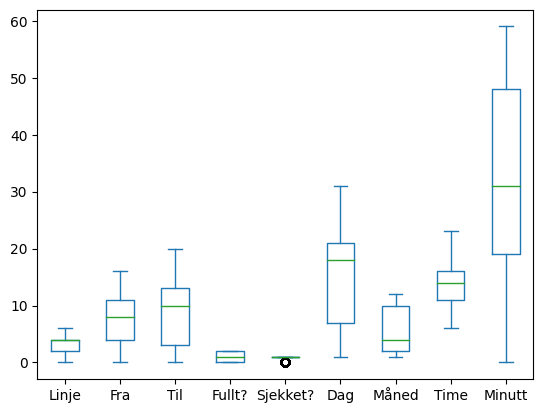

In [1049]:
db.plot.box()

# Synthetic data

### SDV

In [1050]:
# sdv = GaussianCopula()
# sdv.fit(db)
# sample = sdv.sample(500)
# sample.head(3)

In [1051]:
# Dont work
#evaluate(sample, db, metrics=['CSTest'], aggregate=False)

In [1052]:
# db = pd.concat([db, sample])

# Creating testing data

In [1053]:
# Create the data to create predict from
X = db.drop(["Sjekket?"], axis=1)

# Create the data to predict to
y = db["Sjekket?"]

### Testing without clock
# X = X.drop(["Klokke"], axis=1)

X.head(3)

,Linje,Fra,Til,Fullt?,Dag,Måned,Time,Minutt
0,5,2,13,2,13,1,8,11
1,2,11,2,2,13,1,11,54
2,2,11,3,2,13,1,11,54


# Train_test_split

In [1054]:
# Split the data into train and test sets with test_size=0.2 and random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating model1 - XGBoostClassifier

In [1055]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [1056]:
preds = model.predict(X_test)

## Model 1 testing

### Model 1's confusion matrix

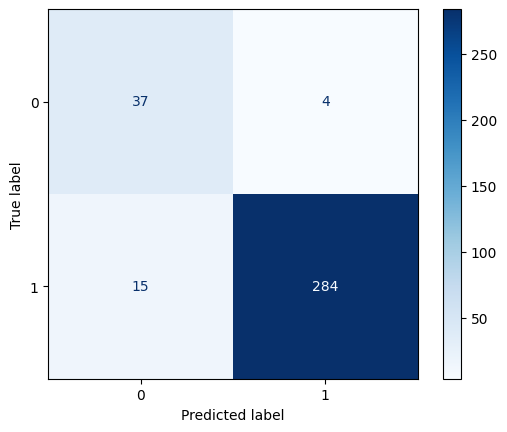

In [1057]:
cm = confusion_matrix(y_true=y_test, y_pred=preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot(cmap='Blues')

In [1058]:
accuracy = accuracy_score(y_true=y_test, y_pred=preds)
print(f"Accuracy: {accuracy * 100.0 :.2f}")

Accuracy: 94.41


### Model 1's feature importance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

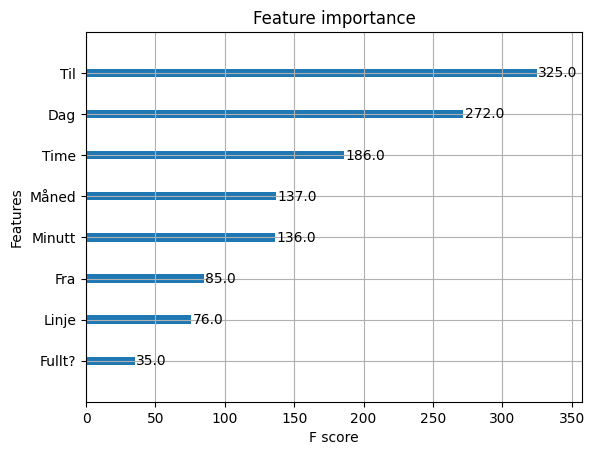

In [1059]:
xgb.plot_importance(model)

# Creating model 2 - Model 1 with optuna

In [1060]:
def objective(trial):
    """The objective is to find the best parameters for the most accuracy in the model"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1e+3),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss'
    }

    # Fit the model
    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = opt.create_study(direction="maximize")
study.optimize(objective, n_trials=TWO_TRIALS)

[I 2023-05-15 01:09:35,455] A new study created in memory with name: no-name-cdb74a02-9bc3-44cb-93e2-729599febc49
[I 2023-05-15 01:09:35,667] Trial 0 finished with value: 0.8794117647058823 and parameters: {'max_depth': 2, 'learning_rate': 0.5370433737555854, 'n_estimators': 400, 'min_child_weight': 7, 'gamma': 772.6049161831534, 'subsample': 0.4073688611361121, 'colsample_bytree': 0.5443271837641853, 'reg_alpha': 0.527439601415718, 'reg_lambda': 0.7405479868186251}. Best is trial 0 with value: 0.8794117647058823.
[I 2023-05-15 01:09:35,704] Trial 1 finished with value: 0.8794117647058823 and parameters: {'max_depth': 5, 'learning_rate': 0.07295872368278021, 'n_estimators': 53, 'min_child_weight': 2, 'gamma': 732.0079808651286, 'subsample': 0.4326559186216954, 'colsample_bytree': 0.6841362783401279, 'reg_alpha': 0.7511897302408759, 'reg_lambda': 0.244063942157898}. Best is trial 0 with value: 0.8794117647058823.
[I 2023-05-15 01:09:35,772] Trial 2 finished with value: 0.879411764705882

KeyboardInterrupt: 

In [ ]:
bparams = study.best_params
model2 = xgb.XGBClassifier(**bparams)
model2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7583305474476958, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.9968727308588748, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.5345959677695578, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              n_estimators=488, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
preds2 = model2.predict(X_test)

## Model 2 testing

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

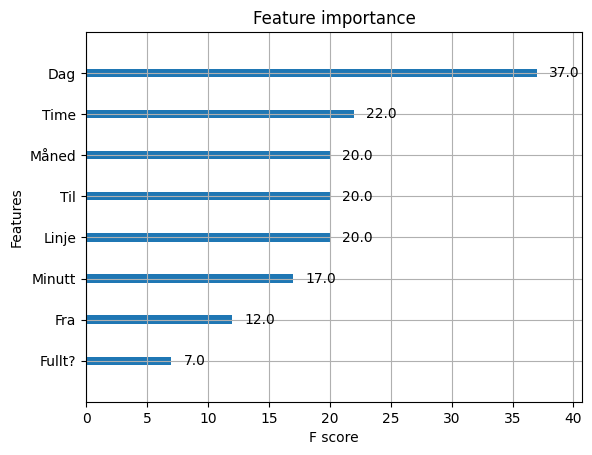

In [ ]:
xgb.plot_importance(model2)

### Model 2 Confusion Matrix

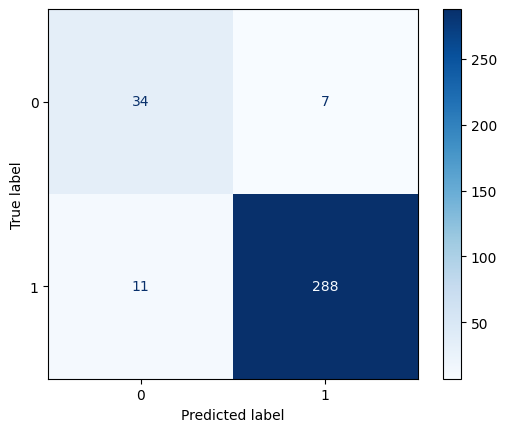

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=preds2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)

disp.plot(cmap='Blues')

In [ ]:
accuracy2 = accuracy_score(y_true=y_test, y_pred=preds2)
print(f"Accuracy: {accuracy2 * 100.0 :.2f}")

Accuracy: 94.71


# Model 3 - Logistic regression

In [ ]:
model3 = LogisticRegression(solver='liblinear', random_state=42)
model3.fit(X_train, y_train)
preds3 = model3.predict(X_test)


## Model 3 testing

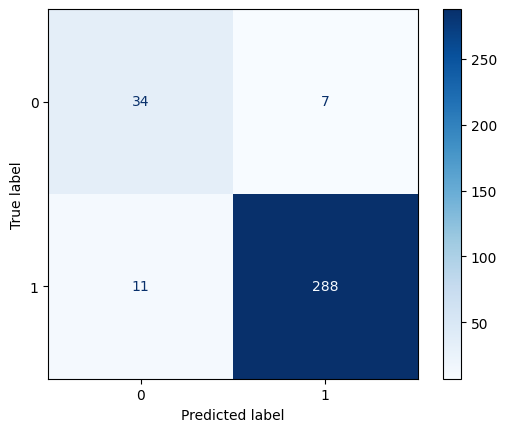

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=preds3)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model3.classes_)

disp.plot(cmap='Blues')

In [ ]:
print(model3.score(X_test, y_test))
accuracy3 = accuracy_score(y_true=y_test, y_pred=preds3)
print(f"Accuracy: {accuracy3 * 100.0 :.2f}")

0.9147058823529411
Accuracy: 91.47


In [ ]:
print(classification_report(y_test, preds3))

              precision    recall  f1-score   support

           0       0.75      0.44      0.55        41
           1       0.93      0.98      0.95       299

    accuracy                           0.91       340
   macro avg       0.84      0.71      0.75       340
weighted avg       0.91      0.91      0.90       340



# Model 4 - Logistic regression with optuna

In [ ]:
heyho = {'hello': 'hi'}

if 'hello' in heyho:
    index = list(heyho.values())[0]

print(index)

hi


In [ ]:
def check_value_exist(dict: dict, liste: list) -> bool:
    do_exist = False
    for l in liste:
            for key, val in dict.items():
                if val == l:
                    do_exist = True
    return do_exist

In [ ]:
def objective(trial):
    """
    Tests parameters for sciKit LogicalRegression
    """


    # Cant use suggest_categorical for multiple strings. Crashes
    # Tried with setting string values from random list number, dont work
    # CANT ACTUALLY SET STRING VALUES WIHTOUT USING CATEGORICAL, and that not workign with multiple
    # Solver
    # solver_num = random.randint(0, 4)
    # solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    solver = 'liblinear' # solver_list[solver_num]
    # fit_intercept
    # fit_num = trial.suggest_int('fit_num', 0, 1)

    params = {
        'tol': trial.suggest_float('tol', 1e-5, 1e-1),
        'C': trial.suggest_float('C', 0.0, 1.0),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'random_state': trial.suggest_int('random_state', 0, 50),
        'intercept_scaling': trial.suggest_float('intercept_scaling', 0, 1.0),
        'solver': trial.suggest_categorical('solver', [solver]),
        'max_iter': trial.suggest_int('max_iter', 0, 60)
    }

    # Pentalty
    #if check_value_exist(params, ['newton-cg', 'lbfgs', 'sag']):
    #    number = random.randint(0, 1)
    #    if number == 1:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["l2"])})
    #    else:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["none"])})
    #elif check_value_exist(params, ['liblinear']):
    #number = random.randint(0, 1)
    #if number == 1:
    params.update({'penalty': trial.suggest_categorical('penalty', ["l1", "l2"])}) # l1 sucks with liblinear, dont use
    #else:
    #    params.update({'penalty': trial.suggest_categorical('penalty', ["l2"])})
    #elif check_value_exist(params, ['saga']):
    #    number = random.randint(0, 3)
    #    if number == 0:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["elasticnet"])})
    #    elif number == 1:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["l2"])})
    #    elif number == 2:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["l1"])})  
    #    else:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["none"])}) 

    # l1_ratio //sucks balls man
    if check_value_exist(params, ['l1', 'elasticnet']):
        params.update({'l1_ratio': trial.suggest_float('l1_ratio', 0.0, 1.0)})

    # Dual
    if check_value_exist(params, ['l2']) and check_value_exist(params, ['liblinear']):
        params.update({'dual': trial.suggest_categorical('dual', [True, False])})
    #else:
    #    params.update({'dual': trial.suggest_categorical('dual', [False])})

    # Fit the model
    optuna_model = LogisticRegression(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = opt.create_study(direction="maximize")
study.optimize(objective, n_trials=FOUR_TRIALS)

[I 2023-05-15 01:00:49,961] A new study created in memory with name: no-name-dfef2dc9-db1a-4edc-b263-7a03020a17b1
/opt/miniconda3/envs/billettkontroll3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-05-15 01:00:49,968] Trial 0 finished with value: 0.9088235294117647 and parameters: {'tol': 0.009826292809450507, 'C': 0.7952897160146913, 'fit_intercept': False, 'random_state': 43, 'intercept_scaling': 0.10805179616795502, 'solver': 'liblinear', 'max_iter': 3, 'penalty': 'l2', 'dual': True}. Best is trial 0 with value: 0.9088235294117647.
/opt/miniconda3/envs/billettkontroll3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-05-15 01:00:49,977] Trial 1 finished with value: 0.9147058823529411 and parameters: {'tol': 0.04863428445077577, 'C': 0.081077228

In [ ]:
bparams = study.best_params
model4 = LogisticRegression(**bparams)
model4.fit(X_train, y_train)
preds4 = model4.predict(X_test)
bparams

/opt/miniconda3/envs/billettkontroll3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'tol': 0.034948404404686675,
 'C': 0.3470779913583514,
 'fit_intercept': True,
 'random_state': 23,
 'intercept_scaling': 0.3740631031936195,
 'solver': 'liblinear',
 'max_iter': 56,
 'penalty': 'l2',
 'dual': True}

## Model 4 testing

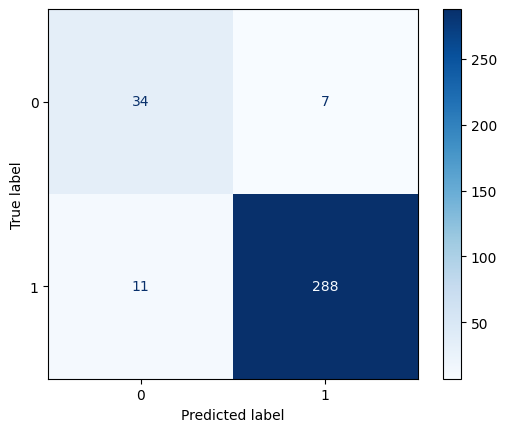

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=preds4)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model4.classes_)

disp.plot(cmap='Blues')

In [ ]:
print(model4.score(X_test, y_test))
accuracy4 = accuracy_score(y_true=y_test, y_pred=preds4)
print(f"Accuracy: {accuracy4 * 100.0 :.2f}")

0.9235294117647059
Accuracy: 92.35


# Best

In [ ]:
accuracies = [accuracy, accuracy2, accuracy3, accuracy4]

counter = 1
best_a = 0
for a in accuracies:
    if a > best_a:
        best = counter
        best_a = a
    
    counter = counter+1

print(f"Best is model number {best} with the score: {best_a * 100 :.2f}")

Best is model number 2 with the score: 94.71


In [ ]:
import json
from datetime import datetime
import pytz
import pickle as pk

In [ ]:
utc = pytz.utc


if best == 1:
    bmodel = model
elif best == 2:
    bmodel = model2
elif best == 3:
    bmodel = model3
else:
    bmodel = model4

try:
    bmodel.save_model("../models/model.h5")
except:
    print("Can't save to H5 format.")

pk.dump(bmodel, open('../models/model.pkl', 'wb'))
pk.dump(best_a, open('../accuracy/accuracy.pkl', 'wb'))

with open("../models/dates.json", "r+") as f:
    data = json.load(f)

with open("../models/dates.json", "w") as f:
    date = datetime.now(utc)
    data["newest_model"] = {"day": date.day, "month": date.month, "year": date.year}
    json.dump(data, f)

If this runs best model is better than altime best model, replace with this

In [ ]:
if SAVE_AS_BEST:
    pk.dump(bmodel, open('../models/best_model.pkl', 'wb'))
    pk.dump(best_a, open('../accuracy/best_accuracy.pkl', 'wb'))

    print(f"This rounds best model with {best_a * 100 :.2f}% was saved as alltime best due to config.")
else:
    best_best_a = pk.load(open('../accuracy/best_accuracy.pkl', 'rb'))

    if best_a > best_best_a:
        pk.dump(bmodel, open('../models/best_model.pkl', 'wb'))
        pk.dump(best_a, open('../accuracy/best_accuracy.pkl', 'wb'))
        best_best_a = best_a

    print(f"Best: {best_a} Best_best: {best_best_a}")

with open("../models/dates.json", "r+") as f:
    data = json.load(f)

with open("../models/dates.json", "w") as f:
    date = datetime.now(utc)
    data["best_model"] = {"day": date.day, "month": date.month, "year": date.year}
    json.dump(data, f)

Best: 0.9470588235294117 Best_best: 0.9676470588235294


In [ ]:
pk.dump(X_test, open('../categories/X_test.pkl', 'wb'))

In [ ]:
if SAVE_AS_BEST or best_a > best_best_a:
    pk.dump(linjeCat, open('../categories/linjeCat.pkl', 'wb'))
    pk.dump(vognCat, open('../categories/vognCat.pkl', 'wb'))
    pk.dump(fraCat, open('../categories/fraCat.pkl', 'wb'))
    pk.dump(tilCat, open('../categories/tilCat.pkl', 'wb'))
    pk.dump(fulltCat, open('../categories/fulltCat.pkl', 'wb'))
    pk.dump(sjekketCat, open('../categories/sjekketCat.pkl', 'wb'))

# Self testing

In [ ]:
X_test.head(5)

,Linje,Fra,Til,Fullt?,Dag,Måned,Time,Minutt
619,4,6,14,2,2,3,20,15
115,4,14,15,2,18,1,16,58
135,4,12,5,2,18,1,17,11
351,2,3,9,1,9,2,11,36
736,6,10,3,0,16,3,15,49


In [ ]:
y_test.head(5)

619    1
115    1
135    1
351    1
736    1
Name: Sjekket?, dtype: int8

In [ ]:
tester = X_test
tester = tester.drop(X_test.index)
tester

# Parameters
linje = "re11"
#vogn = "fremst"
fra = "nationaltheatret"
til = "eidsvoll"
fullt = "ja"
dag = 31
måned = 10
time = 14
minutt = 35

data = {"Linje": [findCatCode(linjeCat, linje)], 
          #"Vogn": [findCatCode(vognCat, vogn)],
          "Fra": [findCatCode(fraCat, fra)], 
          "Til": [findCatCode(tilCat, til)], 
         "Fullt?": [findCatCode(fulltCat, fullt)],
         "Dag": [dag],
         "Måned": [måned],
         "Time": [time],
         "Minutt": [minutt]}

testdb = pd.DataFrame(data)

tester = pd.concat([tester, testdb])
tester


,Linje,Fra,Til,Fullt?,Dag,Måned,Time,Minutt
0,6,8,2,0,31,10,14,35


In [ ]:
# Finds what the number means
ja = findCatCode(sjekketCat, 'ja')
nei = findCatCode(sjekketCat, 'nei')

print(f"{nei} = Nei\n"+
      f"{ja} = Ja")

testpred = bmodel.predict(tester)
print(f"Predicted: {testpred}")

if testpred[0] == ja:
    print("Ja, det er en sannsynlighet for å bli kontrollert")
else:
    print("Nei, det er liten sannsynlighet for å bli kontrollert")

1 = Nei
0 = Ja
Predicted: [1]
Nei, det er liten sannsynlighet for å bli kontrollert


In [ ]:
linjer = list(linjeCat.categories)
linjer

['l1', 'l2', 'r12', 'r13', 'r14', 're10', 're11']